In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [38]:
#imports
import scipy.io
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import math
from typing import List, Tuple
from scipy.sparse.linalg import cg as pcg
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import LinearOperator
from functools import partial
from scipy.sparse import coo_matrix

## converting image.mat to numpy

In [9]:
# Load the MATLAB file
mat = scipy.io.loadmat('image_xyt.mat')

In [10]:
image=mat['image_xyt']

In [11]:
image.shape

(200, 256, 256)

### view fews sample frames

In [12]:
# Computes the fortan like reshape equivalent to matlab reshape
def reshape_fortran(x, shape):
    '''
    Computes the fortan like reshape equivalent to matlab reshape
    Args:
        x: torch.tensor
        shape: Tuple, required shape as matlab reshape
    Returns:
        x_reshpae: torch.tensor reshape x 
        
        REMEMBER THAT THE ERROR CHECKING IS NOT DONE FOR SHAPE COMPABILITY DURING RESHAPE OPERATION.
    
    '''
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape)))).permute(2,0,1)

In [13]:
#function to display random images
def display_random_images(image: np.array,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(image.shape[-1]), k=n)

    # 5. Setup plot
    plt.figure(figsize=(60, 60))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image = image[:,:,targ_sample]
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image,cmap='gray')
        plt.axis("off")
        plt.title(f'Frame No:{targ_sample}',fontsize=25)

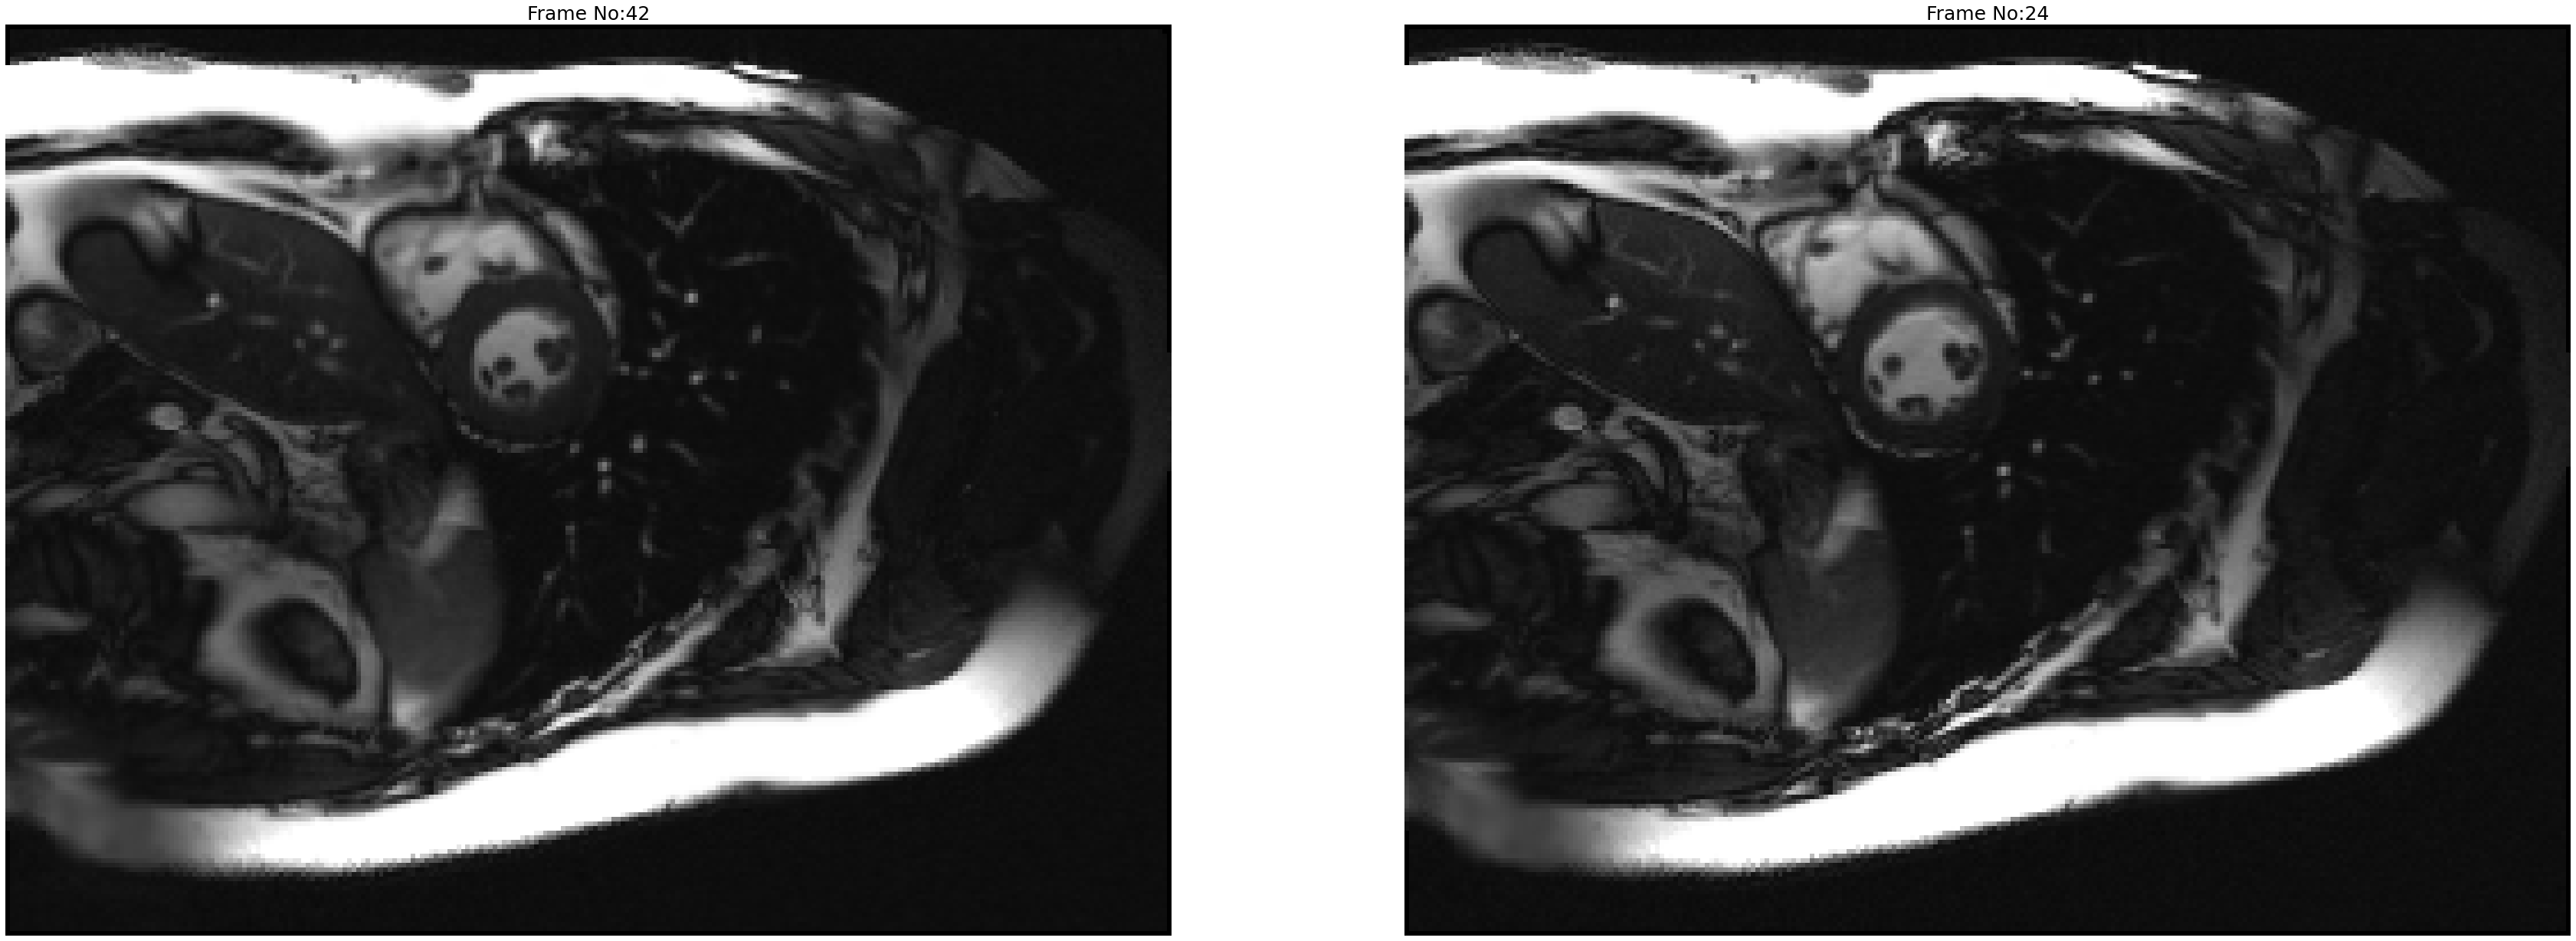

In [14]:
display_random_images(image,n=2)

In [15]:
# defines varibles
#Np: number of phase encodings
Np=image.shape[0]
#number of frequence encodings
Nf= image.shape[1]
#Nnav: Number of navigator lines
Nnav  = 4;

In [16]:
# convert image to tensor
image_tensor= torch.from_numpy(image)
# convert to k-space
Kraw=1/math.sqrt(Np*Nf)*torch.fft.fft2(image_tensor, dim=(1,0))
image_tensor_C= image_tensor.permute(1,0,2).reshape(Np*Nf,image.shape[-1])
Kraw_C=Kraw.permute(1,0,2).reshape(Np*Nf,image.shape[-1])

In [17]:
#  form the k-t space sampling mask 
# Nsam number of sample in k space
Nsam = 32
#nav_ind: A vector containing the indices for navigator lines.
nav_ind = list(range(int(Np/2-Nnav/2),int(Np/2+Nnav/2)))


## function to generate the sampling mask

In [18]:

def tem_sampling_generation(Np, Nfr, Nnav, Nsam):
    # Generate the temporal sampling mask
    # Inputs:
    # Np: number of phase encodings
    # Nfr: number of temporal frames
    # Nnav: number of phase encodings for navigator signal
    # Nsam: number of samples acquired at each k-space location
    #
    # Output:
    # temmask: temporal sampling mask

    temmask = torch.zeros((Np, Nfr))
    nav_ind = np.arange(Np // 2 - Nnav // 2, Np // 2 + Nnav // 2)

    for row in range(Np):
        if row in nav_ind:
            temmask[row, :] = torch.ones(Nfr)
        else:
            temp = torch.zeros(Nfr)
            ind = torch.randperm(Nfr)
            temp[ind[:Nsam]] = 1
            temmask[row, :] = temp

    temmask = temmask.bool()
    return temmask

In [19]:
temmask=tem_sampling_generation(Np,image.shape[-1],Nnav, Nsam)
temmask=torch.fft.fftshift(temmask,dim=0)
Nfr=256
Mask = temmask.repeat(Nf,1)
d_c=Kraw_C*Mask
d=d_c.T.flatten()
# get the indices of non-zero elements in x
nonzero_indices = torch.nonzero(d)
# extract the non-zero elements from x
d = d[nonzero_indices]
d=d.to(torch.complex64)

In [20]:
d.shape

torch.Size([1867776, 1])

In [21]:
nav_location = torch.zeros((Np, 1),dtype=torch.bool)
nav_location[nav_ind] = 1

In [22]:
Navdata=Kraw[torch.fft.fftshift(nav_location).squeeze(1),:,:].permute(1,0,2).reshape(Nnav*Nf,image.shape[-1])
# order of the model
r=32
#perform SvD
u_np, s_np, vh_np = torch.svd(Navdata)
vh_np=vh_np[:,:r]
V_Tr=-vh_np.T

In [23]:
V_Tr=V_Tr.to(torch.complex64)

In [24]:
V_Tr

tensor([[ 0.0633+0.0000e+00j,  0.0633-9.7174e-06j,  0.0633-1.4203e-06j,
          ...,  0.0629+2.1409e-05j,  0.0629+2.4980e-05j,
          0.0629+2.4864e-05j],
        [ 0.0119+0.0000e+00j,  0.0144-4.1029e-03j,  0.0152-8.7133e-03j,
          ...,  0.0068-1.9064e-03j,  0.0058-9.6684e-04j,
          0.0041+3.1558e-03j],
        [-0.1087+0.0000e+00j, -0.1063-9.7147e-05j, -0.1017-4.9150e-04j,
          ..., -0.0530+1.1160e-03j, -0.0512+1.0701e-03j,
         -0.0534+1.1523e-03j],
        ...,
        [ 0.0740+0.0000e+00j, -0.0253-3.6557e-02j, -0.0023-3.4161e-02j,
          ..., -0.0299+3.5844e-02j, -0.0192+2.6058e-02j,
          0.0268-3.2883e-03j],
        [ 0.0709+0.0000e+00j,  0.0329-6.3735e-02j,  0.0108-1.6907e-02j,
          ...,  0.0112-1.5290e-02j,  0.0021+1.1129e-02j,
         -0.0015+4.7192e-03j],
        [ 0.0233+0.0000e+00j, -0.0501+3.7162e-02j, -0.0025+1.1238e-02j,
          ..., -0.0146+2.9937e-02j,  0.0032+3.5322e-02j,
         -0.0150+2.0078e-02j]])

In [25]:
# mu: regularization parameter
# beta: initial value of continuation parameter
beta = 1e3
mu   = 2.5e-6

In [26]:
#inital value of Us_r0
Us_r0=torch.zeros((Np*Nf,r),dtype=torch.complex64)

## PS -Sparse reconstruction method

In [27]:
def normal_oper(Uk_r, Vt_r, Rind, Cind, Mask):
    N = Mask.shape[0]
    M = Mask.shape[1]
    r = Vt_r.shape[0]
    
    G = np.reshape(Uk_r, (N, r)) @ Vt_r
    d = G.T[Mask.T]
    
    UU = coo_matrix((d, (Rind, Cind)), shape=(N, M)) @ Vt_r.T
    UU = np.reshape(UU, (N * r, 1))
    
    return UU

In [21]:
def lin_op_func(x, Vt_r, Rind, Cind, Mask, mu, beta):
    return normal_oper(x, Vt_r, Rind, Cind, Mask) +  np.expand_dims(mu * beta / 2 * x,axis=1)

In [22]:
def ps_sparse_recon(d:torch.tensor,
                   M: torch.tensor,
                   Us_r: torch.tensor,
                   Vt_r: torch.tensor,
                   mu: float,
                   beta: float,
                   regularizer: str,
                   Np: int,
                   Nf: int,
                   Nfr: int):
    '''This code performs image reconstruction from highly undersampled data using
    joint partial separability (PS) and sparsity constraints
    
    Args:
        d: measured data undersampled  Size([1867776, 1])
        Mask: k-t space sampling mask Size([51200, 256])
        Us_r: initial value of Us_r Size([51200, 32])
        Vt_r: basis for the temporal subspace Size([32, 256])
        mu: regularization parameter 
        beta: initial value of continuation parameter
        regularizer: spa_reg for spatial sparsity regularization
        Np: number of phase encodings
        Nf: number of frequence encodings
        Nfr: number of temporal frames
    Return:
        Us_r: basis for the spatial subspace
    '''
    #tolerance for error
    tol = 1e-5
    #maximum number of iterations
    maxit = 200
    
    # size of temporal basis
    r= Us_r.shape[-1]
    # get the rows and column index of the non-zero mask
    Rind,Cind=(torch.nonzero(Mask.T))[:,[1,0]][:,0],(torch.nonzero(Mask.T))[:,[1,0]][:,1]
    # create the sparse matrix
    sparse_matrix = torch.sparse_coo_tensor(indices=torch.stack((Rind, Cind)), values=d.squeeze(), size=[Np*Nf, Nfr])

    # multiply the sparse matrix by Vt_r
    bb = torch.sparse.mm(sparse_matrix,V_Tr.t()).numpy()
    
    #initilize U_kr
    Uk_r =1/math.sqrt(Np*Nf)*torch.fft.fft2(Us_r0, dim=(1,0))
    Uk_r=Uk_r.permute(1,0).reshape(Np*Nf,r)
    Uk_r=Uk_r.numpy()
    Us_r_last = Us_r.numpy()
    #V_fr
    V_Fr=1/math.sqrt(Nfr)*torch.fft.fft(V_Tr,dim=1)
    
    #outer loop
    for i in range(0,5):
        print(f"The outerloop loop is {i}")
        for j in range(0,100):
            print(f"The inner loop is {j}")
            Gs=torch.sgn(torch.matmul(Us_r,V_Fr))*torch.threshold(torch.abs(torch.matmul(Us_r,V_Fr)), 1/beta, 0)@V_Fr.T
            #switching to numpy reshape errors
            Gs_np=Gs.numpy()
            Gk=1/math.sqrt(Np*Nf)*np.fft.fft2((np.reshape(Gs_np,(Np,Nf,r),order='F')),axes=(1,0))
            b=bb+mu*beta/2*np.reshape(Gk,(Np*Nf,r),order='F')
            lin_op = LinearOperator((Np * Nf * r, Np * Nf * r), matvec=lambda x: lin_op_func(x, V_Tr.numpy(), Rind, Cind, Mask, mu, beta))
            Uk_r, _ = pcg(lin_op, b.flatten(), tol=tol, maxiter=maxit, x0=Uk_r.flatten())
            Uk_r = np.reshape(Uk_r, (Np * Nf, r), order='F')
            Us_r = np.sqrt(Np * Nf) * np.fft.ifft2(np.reshape(Uk_r, (Np, Nf, r),order='F'), axes=(1,0))
            Us_r = np.reshape(Us_r, (Np * Nf, r), order='F')
            relchange_Us = np.linalg.norm(Us_r.flatten() - Us_r_last.flatten()) / np.linalg.norm(Us_r_last.flatten())
            Us_r_last = Us_r
            Us_r=torch.from_numpy(Us_r)
            Us_r=Us_r.to(torch.complex64)
            if relchange_Us < 1e-4:
                break
            beta = 10 * beta
    return Us_r.numpy()

In [28]:
#tolerance for error
tol = 1e-5
#maximum number of iterations
maxit = 200

In [29]:
# size of temporal basis
r= Us_r0.shape[-1]
# get the rows and column index of the non-zero mask
Rind,Cind=(torch.nonzero(Mask.T))[:,[1,0]][:,0],(torch.nonzero(Mask.T))[:,[1,0]][:,1]
# create the sparse matrix
sparse_matrix = torch.sparse_coo_tensor(indices=torch.stack((Rind, Cind)), values=d.squeeze(), size=[Np*Nf, Nfr])
# multiply the sparse matrix by Vt_r
bb = torch.sparse.mm(sparse_matrix,V_Tr.t()).numpy()

In [30]:
#initilize U_kr
Uk_r =1/math.sqrt(Np*Nf)*torch.fft.fft2(Us_r0, dim=(1,0))
Uk_r=Uk_r.permute(1,0).reshape(Np*Nf,r)
Uk_r=Uk_r.numpy()

In [31]:
 #V_fr
V_Fr=1/math.sqrt(Nfr)*torch.fft.fft(V_Tr,dim=1)
    

In [32]:
Gs=torch.sgn(torch.matmul(Us_r0,V_Fr))*torch.threshold(torch.abs(torch.matmul(Us_r0,V_Fr)), 1/beta, 0)@V_Fr.T
#switching to numpy reshape errors
Gs_np=Gs.numpy()

In [33]:
Gk=1/math.sqrt(Np*Nf)*np.fft.fft2((np.reshape(Gs_np,(Np,Nf,r),order='F')),axes=(1,0))

In [159]:
b=bb+mu*beta/2*np.reshape(Gk,(Np*Nf,r),order='F')

In [91]:
type(V_Tr)

numpy.ndarray

In [161]:
# Define the normal_oper function (using the provided implementation)
def normal_oper(Uk_r, Vt_r, Rind, Cind, Mask):
    Mask=Mask.numpy()
    N = Mask.shape[0]
    M = Mask.shape[1]
    r = Vt_r.shape[0]
    G = np.reshape(Uk_r, (N, r),order='F') @ Vt_r
    d = G.T[Mask.T]
    del G
    UU = coo_matrix((d, (Rind, Cind)), shape=(N, M)).toarray() @ Vt_r.T
    UU = np.reshape(UU, (N * r,),order='F')
    return UU

In [150]:
V_Tr=V_Tr.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [162]:
# Define a linear operator for the matrix-vector multiplication
def funcd(x):
    result = normal_oper(x, V_Tr, Rind, Cind, Mask) + mu * beta / 2 * x
    return result


In [167]:
V_Tr

array([[ 0.06334065+0.0000000e+00j,  0.06330606-9.7174316e-06j,
         0.06332986-1.4203463e-06j, ...,  0.06286291+2.1409469e-05j,
         0.06290121+2.4980485e-05j,  0.06294336+2.4864185e-05j],
       [ 0.01191323+0.0000000e+00j,  0.01435174-4.1028890e-03j,
         0.01521467-8.7132566e-03j, ...,  0.0068045 -1.9064108e-03j,
         0.00580935-9.6683676e-04j,  0.00414106+3.1558122e-03j],
       [-0.10868425+0.0000000e+00j, -0.10627282-9.7146607e-05j,
        -0.10165193-4.9150223e-04j, ..., -0.05304796+1.1160494e-03j,
        -0.05120607+1.0700873e-03j, -0.05342064+1.1522785e-03j],
       ...,
       [ 0.07399283+0.0000000e+00j, -0.02529653-3.6557041e-02j,
        -0.00231936-3.4161076e-02j, ..., -0.02994084+3.5843655e-02j,
        -0.01924446+2.6058270e-02j,  0.02677244-3.2882730e-03j],
       [ 0.0708531 +0.0000000e+00j,  0.03293927-6.3734688e-02j,
         0.01081319-1.6906774e-02j, ...,  0.01122117-1.5290191e-02j,
         0.00207251+1.1128983e-02j, -0.00148144+4.7191577e-03j]

In [163]:
A = LinearOperator((Np * Nf * r, Np * Nf * r), matvec=funcd)

In [164]:
# Solve the linear system using the PCG method
solution, info = pcg(A, b.ravel(order='F'), tol=tol, maxiter=100, x0=Uk_r.ravel(order='F'))

In [154]:
info

100

In [155]:
solution

array([-4.38366515+0.21360189j, -0.91943662-0.29138695j,
       -0.07097312-7.94508946j, ..., -0.28766885-0.44620009j,
       -0.04103784+0.025041j  , -0.00612408+0.06121232j])

In [156]:
# Compute Ax using the solution vector x
Ax = funcd(solution)

In [160]:
b.ravel(order='F')

array([ 2.94762760e-01+1.52114531e-04j,  6.07764795e-02+2.24618297e-02j,
       -4.80548060e-03-2.25212565e-03j, ...,
       -1.55731163e-04-8.42972076e-05j, -1.30473927e-06-1.47173596e-05j,
        7.81008202e-06-2.15501568e-05j])

In [158]:
Ax

array([-4.38879303e+00+0.20883035j, -9.19931748e-01-0.29348019j,
       -2.41446426e-01-1.20123099j, ...,  4.95971111e-02-0.13553027j,
        4.86998425e-02-0.01003163j, -3.95225015e-03-0.02242785j])

In [213]:
# Define the combined linear operator
def combined_matvec(x, Vt_r, Rind, Cind, Mask, mu, beta):
    return normal_oper(x, Vt_r, Rind, Cind, Mask) + (mu * beta / 2) * x

In [214]:
# Use functools.partial to include additional arguments
matvec = partial(combined_matvec, Vt_r=V_Tr, Rind=Rind, Cind=Cind, Mask=Mask, mu=mu, beta=beta)

In [215]:
A = LinearOperator(shape=(n, n), matvec=matvec, dtype=np.float64)

In [219]:
# Solve using the Preconditioned Conjugate Gradient (PCG) method
x, info = pcg(A, b.ravel(order='F'), tol=1e-5, maxiter=200, M=None, x0=Uk_r.ravel(order='F'))

In [222]:
b.ravel(order='F')

array([ 2.94762760e-01+1.52114531e-04j,  6.07764795e-02+2.24618297e-02j,
       -4.78795823e-03-2.27928697e-03j, ...,
       -5.16364526e-05-6.66445994e-04j, -1.30473927e-06-1.47173596e-05j,
        7.81008202e-06-2.15501568e-05j])

In [218]:
Uk_r.ravel(order='F')

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      dtype=complex64)

In [77]:
info

200

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [80]:
#test

In [99]:
from scipy.sparse import coo_matrix

In [129]:
def normal_oper(Uk_r, Vt_r, Rind, Cind, Mask):
    N = Mask.shape[0]
    M = Mask.shape[1]
    r = Vt_r.shape[0]
    
    G = np.reshape(Uk_r, (N, r)) @ Vt_r
    d = G.T[Mask.T]
    
    UU = coo_matrix((d, (Rind, Cind)), shape=(N, M)) @ Vt_r.T
    UU = np.reshape(UU, (N * r, 1))
    
    return UU

In [130]:
def lin_op_func(x, Vt_r, Rind, Cind, Mask, mu, beta):
    return normal_oper(x, Vt_r, Rind, Cind, Mask) +  np.expand_dims(mu * beta / 2 * x,axis=1)

In [131]:
lin_op = LinearOperator((Np * Nf * r, Np * Nf * r), matvec=lambda x: lin_op_func(x, V_Tr, Rind, Cind, Mask, mu, beta))
Uk_r, _ = pcg(lin_op, b.flatten(), tol=tol, maxiter=maxit, x0=Uk_r.flatten())

In [128]:
Uk_r

array([-10.13485725+2.14583604j,   1.55490665+0.60902133j,
        -1.63630482-1.10407622j, ...,   0.16510397+0.03778242j,
         0.10295252+0.14576068j,  -0.01521556+0.17454461j])

In [133]:
#main test

In [273]:
def normal_oper(Uk_r, V_Tr, Rind, Cind, Mask):
    N = Mask.shape[0]
    M = Mask.shape[1]
    r = V_Tr.shape[0]
   
    G = np.reshape(Uk_r, (N, r)) @ V_Tr
    d = G.T[Mask.T]
    d=torch.from_numpy(d)
    d=d.to(torch.complex64)
     # create the sparse matrix
    sparse_matrix = torch.sparse_coo_tensor(indices=torch.stack((Rind, Cind)), values=d.squeeze(), size=[N,M])

    # multiply the sparse matrix by Vt_r
    x=torch.from_numpy(V_Tr)
    x=x.to(torch.complex64)
    UU = torch.sparse.mm(sparse_matrix,x.t()).numpy()
    UU = np.reshape(UU, (N * r), order='F')
    
    return UU

In [282]:
Mask.shape

torch.Size([51200, 256])

In [279]:
A = LinearOperator((Np * Nf * r, Np * Nf * r), matvec=lambda x: normal_oper(x, V_Tr, Rind, Cind, Mask)+mu * beta / 2 * x.ravel())

In [280]:
sol, _ = pcg(A, b.ravel(), tol=tol, maxiter=maxit, x0=Uk_r.ravel())

In [281]:
sol

array([5804.11928437+4.19578316e+04j, 1836.26956884-5.78464321e+03j,
        -63.7715437 +2.96670115e+02j, ...,   -8.52374925+4.17746649e-01j,
         -7.73948577+1.12060303e+01j,   18.80915613-1.61795043e+01j])

In [278]:
normal_oper(Uk_r,V_Tr,Rind,Cind,Mask)+mu * beta / 2 * Uk_r.ravel()

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      dtype=complex64)

In [237]:
b

array([[ 2.94762760e-01+1.52114531e-04j, -7.00459859e-05+2.34390172e-04j,
         3.39216786e-04+1.32678018e-04j, ...,
        -5.33007551e-07+5.76438470e-06j, -6.35696233e-06+3.07939627e-06j,
         5.11243707e-06-5.02952025e-06j],
       [ 6.07764795e-02+2.24618297e-02j,  1.15743757e-03-5.19038003e-04j,
         4.24568250e-04+8.00848240e-04j, ...,
         1.43684883e-06+6.39657083e-06j, -4.73386626e-06-1.31072211e-05j,
         1.82118674e-06+9.08115180e-06j],
       [-4.78795823e-03-2.27928697e-03j, -2.01364921e-04+1.84868273e-04j,
        -6.99878903e-04-4.75612993e-04j, ...,
         4.67683480e-04+6.36404438e-04j,  2.63559690e-04+6.42774467e-05j,
         2.03646159e-05+6.51260198e-05j],
       ...,
       [ 4.59987577e-03-1.77031278e-03j, -5.04557902e-05+1.49129110e-03j,
        -3.54080898e-04+3.59391095e-04j, ...,
        -6.27343717e-04+5.61825407e-04j,  2.28172663e-04-1.71804801e-04j,
        -5.16364526e-05-6.66445994e-04j],
       [ 6.41125999e-03+5.07115945e-02j, -6.